# Импорт библиотек

In [ ]:
import pandas as pd
import numpy as np

from selenium import webdriver
from selenium.webdriver.firefox.service import Service as FirefoxService
from selenium.webdriver.chrome.service import Service as ChromeService
# from selenium.webdriver.firefox.options import Options
from selenium.webdriver.firefox.options import Options as FirefoxOptions
from selenium.webdriver.chrome.options import Options as ChromeOptions
from selenium.webdriver import Keys
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from webdriver_manager.firefox import GeckoDriverManager
from webdriver_manager.chrome import ChromeDriverManager
from fake_useragent import UserAgent
import requests
from bs4 import BeautifulSoup as bs

from time import sleep
import random


pd.set_option('display.max_columns', None)


In [ ]:
import re

import matplotlib.pyplot as plt
import seaborn as sns

# Обоснование выбора компании и датасета

[Ссылка на данные](https://www.kaggle.com/datasets/sakshigoyal7/credit-card-customers)



#### Легенда       
Мы команда продуктовых аналитиков направления кредитные карты в компании American Express. В последние данные прослеживается тренд снижения популярности данного продукта. *(вот что надумал из того, что можно добавить. мы же не совсем момент с популярностью решаем, а скорее работаем с возможным оттоком клиентов. можно сказать, что мы фиксируем (на фоне рецессии в Америке, хз) отток клиентов, и мы хотим работать с этими случаями, предлагая им кэшбек, выгодные условия снятия налички, сниженную комиссию, скидку на обслуживание и т.д. типа пользователи хотят пользоваться картами, но уходят к конкурентам, например, хз, к эппл пэй)*     

В связи с этим необходимо:
1. Проанализировать отток клиентов банка (отказы от кредитных карт)
2. Составить профили пользователей кредитных карт и потенциальных отказников
3. Построить модель, которая бы наиболее точно предсказывала, кто из клиентов наиболее вероятно откажется от продукта

Таким образом, перед нами в первую очередь стоит задача решить проблему бинарной классификации: 1 (клиент ушел) или 0 (клиент остался с нами)

In [ ]:
df = pd.read_csv('BankChurners.csv')


df = df.drop(['Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1',
       'Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2'], axis=1)
print(df.shape)
df.head()

(10127, 21)


,CLIENTNUM,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio
0,768805383,Existing Customer,45,M,3,High School,Married,$60K - $80K,Blue,39,5,1,3,12691.0,777,11914.0,1.335,1144,42,1.625,0.061
1,818770008,Existing Customer,49,F,5,Graduate,Single,Less than $40K,Blue,44,6,1,2,8256.0,864,7392.0,1.541,1291,33,3.714,0.105
2,713982108,Existing Customer,51,M,3,Graduate,Married,$80K - $120K,Blue,36,4,1,0,3418.0,0,3418.0,2.594,1887,20,2.333,0.000
3,769911858,Existing Customer,40,F,4,High School,Unknown,Less than $40K,Blue,34,3,4,1,3313.0,2517,796.0,1.405,1171,20,2.333,0.760
4,709106358,Existing Customer,40,M,3,Uneducated,Married,$60K - $80K,Blue,21,5,1,0,4716.0,0,4716.0,2.175,816,28,2.500,0.000


In [ ]:
df.columns

Index(['CLIENTNUM', 'Attrition_Flag', 'Customer_Age', 'Gender',
       'Dependent_count', 'Education_Level', 'Marital_Status',
       'Income_Category', 'Card_Category', 'Months_on_book',
       'Total_Relationship_Count', 'Months_Inactive_12_mon',
       'Contacts_Count_12_mon', 'Credit_Limit', 'Total_Revolving_Bal',
       'Avg_Open_To_Buy', 'Total_Amt_Chng_Q4_Q1', 'Total_Trans_Amt',
       'Total_Trans_Ct', 'Total_Ct_Chng_Q4_Q1', 'Avg_Utilization_Ratio',
       'Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1',
       'Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2'],
      dtype='object')

In [ ]:
df.Income_Category.unique()

array(['$60K - $80K', 'Less than $40K', '$80K - $120K', '$40K - $60K',
       '$120K +', 'Unknown'], dtype=object)

In [ ]:
df.groupby(['Card_Category'])['CLIENTNUM'].agg('count')

Card_Category
Blue        9436
Gold         116
Platinum      20
Silver       555
Name: CLIENTNUM, dtype: int64

In [ ]:
df[df['Income_Category']=='Less than $40K'].groupby(['Card_Category'])['CLIENTNUM'].agg('count')

Card_Category
Blue        3403
Gold          24
Platinum       4
Silver       130
Name: CLIENTNUM, dtype: int64

In [ ]:
df[df['Income_Category']=='$120K +'].groupby(['Card_Category'])['CLIENTNUM'].agg('count')

Card_Category
Blue        645
Gold         18
Platinum      4
Silver       60
Name: CLIENTNUM, dtype: int64

# Дополнительные фичи

# Дополнение датафрейма
1. Цена обслуживания разных типов карт (парсинг)   
Источник: [American Express](https://www.americanexpress.com/us/credit-cards/?category=all&eep=25330&intlink=US-Axp-Shop-Consumer-VAC-Prospect-all-StickyFilter)
2. Категории населения по возрасту + статистика в разрезе США (файл)  
Источник: [Neilsberg](https://www.neilsberg.com/insights/united-states-population-by-age/)

In [ ]:
def site_open_func(site: str, browser: str = 'firefox'):
    ua = UserAgent()

    if browser == 'firefox':
        service = FirefoxService(GeckoDriverManager().install())
        user_agent = ua.firefox
        options = FirefoxOptions()
        options.set_preference("general.useragent.override", user_agent)

        driver = webdriver.Firefox(service=service, options=options)
    else:
        raise ValueError("Unsupported browser. Choose 'firefox' or 'chrome'.")

    url = site
    driver.get(url)
    sleep(3)

    return driver, url

In [ ]:
# Флаг для парсинга цен по картам
parse_card_info_flg = False

In [ ]:
if parse_card_info_flg:
    site = 'https://www.americanexpress.com/us/credit-cards/?category=all&eep=25330&intlink=US-Axp-Shop-Consumer-VAC-Prospect-all-StickyFilter'
    driver = site_open_func(site, 'firefox')
    page_blue_card = bs(driver.page_source)
    df_card_info = pd.DataFrame(columns=['Card', 'Annual fee'])

    for card in page_blue_card.find_all(True):
        try:
            if card.find('strong', class_='dls-deep-blue', string='Annual Fee'):
                card_name = card.find_previous('h2').get_text(strip=True)
                fee_span = card.find('span')
                html_string = str(fee_span)

                import re
                dollar_amounts = re.findall(r'\$\d+', html_string)

                if dollar_amounts:
                    annual_fee = dollar_amounts[0].replace('$', '')
                    # print(card_name, annual_fee)

                    card_exists = (df_card_info['Card'] == card_name).any()

                    if annual_fee is not None and not card_exists:
                        df_card_info.loc[len(df_card_info)] = {
                            'Card': card_name,
                            'Annual fee': annual_fee
                        }

        except Exception as e:
            pass

In [ ]:
if parse_card_info_flg:

    df_card_info.loc[len(df_card_info), :] = ['Blue Cash Everyday Card', 0]
    df_card_info['Annual fee'] = df_card_info['Annual fee'].astype(int)
    df_card_info['Card'] = df_card_info['Card'].str.replace('®', ' ').str.strip()
    df_card_info.loc[2, 'Annual fee'] = 95 #точечная корректировка (комплексное условие)

    dict_card_names = {
                    'Blue':'Blue Cash Everyday Card',
                    'Silver':'American Express Green Card',
                    'Gold':'American Express Gold Card',
                    'Platinum':'The Platinum Card',
                    }
    dict_card_names_reverse = {v: k for k, v in dict_card_names.items()}


    df_card_info.loc[:, 'Card_Category'] = df_card_info['Card'].map(dict_card_names_reverse)
    df_card_info.Card_Category = df_card_info.Card_Category.fillna('Other')
    df_card_info.to_csv('Парсинг_цена_карт.csv', index=False)

In [ ]:
df_age_group = pd.read_csv('population_age_category.csv')
df_age_group.Population = df_age_group.Population.str.replace(',', '').astype('float')
df_age_group['% of Total Population'] = df_age_group['% of Total Population'].str.replace('%', '').astype('float') / 100

print(df_age_group.shape)
df_age_group.head(2)

(18, 3)


,Age Group,Population,% of Total Population
0,Under 5 years,18939899.0,0.0570
1,5 to 9 years,20102351.0,0.0605


In [ ]:
def extract_age_bounds(age_str):
    numbers = re.findall(r'\d+', age_str)

    if "Under" in age_str:
        return 0, int(numbers[0]) - 1
    elif "and over" in age_str:
        return int(numbers[0]), None
    elif len(numbers) == 2:
        return int(numbers[0]), int(numbers[1])
    else:
        return None, None

df_age_group[['age_from', 'age_to']] = df_age_group['Age Group'].apply(
    lambda x: pd.Series(extract_age_bounds(x))
)

In [ ]:
# Присоединяем новые фичи
df_2 = df.copy().reset_index(drop=True)
df_age_group = df_age_group.reset_index(drop=True)


def find_age_group(age):
    mask = (
        (df_age_group['age_from'] <= age) & (df_age_group['age_to'] >= age)
    )
    matching_rows = df_age_group[mask]

    if not matching_rows.empty:
        return matching_rows.iloc[0][['Age Group', 'Population', '% of Total Population']]
    else:
        # Возвращаем NaN или дефолтные значения, если группа не найдена
        return pd.Series([None, None, None], index=['Age Group', 'Population', '% of Total Population'])

# Применяем и создаем новые колонки
age_group_data = df_2['Customer_Age'].apply(find_age_group)
df_2 = pd.concat([df_2, age_group_data.apply(pd.Series)], axis=1)

df_2.head(2)

,CLIENTNUM,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio,Age Group,Population,% of Total Population
0,768805383,Existing Customer,45,M,3,High School,Married,$60K - $80K,Blue,39,5,1,3,12691.0,777,11914.0,1.335,1144,42,1.625,0.061,45 to 49 years,20051874.0,0.0603
1,818770008,Existing Customer,49,F,5,Graduate,Single,Less than $40K,Blue,44,6,1,2,8256.0,864,7392.0,1.541,1291,33,3.714,0.105,45 to 49 years,20051874.0,0.0603


In [ ]:
df_card_info = pd.read_csv('Парсинг_цена_карт.csv')
df_2 = df_2.merge(df_card_info, how='left', on='Card_Category')

In [ ]:
# удалить для запуска с нуля
# df_2.to_parquet('BankChurners_add_features.parquet')

In [2]:
import pandas as pd

# Загрузка parquet-файла
df_2 = pd.read_parquet('BankChurners_add_features.parquet')

# Просмотр первых строк
df_2.head()


,CLIENTNUM,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,...,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio,Age Group,Population,% of Total Population,Card,Annual fee
0,768805383,Existing Customer,45,M,3,High School,Married,$60K - $80K,Blue,39,...,1.335,1144,42,1.625,0.061,45 to 49 years,20051874.0,0.0603,Blue Cash Everyday Card,0
1,818770008,Existing Customer,49,F,5,Graduate,Single,Less than $40K,Blue,44,...,1.541,1291,33,3.714,0.105,45 to 49 years,20051874.0,0.0603,Blue Cash Everyday Card,0
2,713982108,Existing Customer,51,M,3,Graduate,Married,$80K - $120K,Blue,36,...,2.594,1887,20,2.333,0.000,50 to 54 years,20795839.0,0.0626,Blue Cash Everyday Card,0
3,769911858,Existing Customer,40,F,4,High School,Unknown,Less than $40K,Blue,34,...,1.405,1171,20,2.333,0.760,40 to 44 years,21239767.0,0.0639,Blue Cash Everyday Card,0
4,709106358,Existing Customer,40,M,3,Uneducated,Married,$60K - $80K,Blue,21,...,2.175,816,28,2.500,0.000,40 to 44 years,21239767.0,0.0639,Blue Cash Everyday Card,0


In [ ]:
df_2.head()

,CLIENTNUM,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio,Age Group,Population,% of Total Population,Card,Annual fee
0,768805383,Existing Customer,45,M,3,High School,Married,$60K - $80K,Blue,39,5,1,3,12691.0,777,11914.0,1.335,1144,42,1.625,0.061,45 to 49 years,20051874.0,0.0603,Blue Cash Everyday Card,0
1,818770008,Existing Customer,49,F,5,Graduate,Single,Less than $40K,Blue,44,6,1,2,8256.0,864,7392.0,1.541,1291,33,3.714,0.105,45 to 49 years,20051874.0,0.0603,Blue Cash Everyday Card,0
2,713982108,Existing Customer,51,M,3,Graduate,Married,$80K - $120K,Blue,36,4,1,0,3418.0,0,3418.0,2.594,1887,20,2.333,0.000,50 to 54 years,20795839.0,0.0626,Blue Cash Everyday Card,0
3,769911858,Existing Customer,40,F,4,High School,Unknown,Less than $40K,Blue,34,3,4,1,3313.0,2517,796.0,1.405,1171,20,2.333,0.760,40 to 44 years,21239767.0,0.0639,Blue Cash Everyday Card,0
4,709106358,Existing Customer,40,M,3,Uneducated,Married,$60K - $80K,Blue,21,5,1,0,4716.0,0,4716.0,2.175,816,28,2.500,0.000,40 to 44 years,21239767.0,0.0639,Blue Cash Everyday Card,0


# Описание полученных фичей

- `CLIENTNUM` — уникальный номер клиента
- `Attrition_Flag` — счет закрыт или открыт
- `Customer_Age` — возраст клиента
- `Gender` — пол клиента
- `Dependent_count` — скольких человек обеспечивает клиент
- `Education_Level` — образовательная степень клиента
- `Marital_Status` — семейный статус
- `Income_Category` — доход клиента
- `Card_Category` — вид карты (классификация American Express)
- `Months_on_book` — в течении скольких месяцев клиент сотрудничает с банком
- `Total_Relationship_Count` — количество продуктов, которым обладает клиент
- `Months_Inactive_12_mon` — в течении сколькиз месяцев из последних 12 клиент был неактивен
- `Contacts_Count_12_mon` — количество контактов (со службой поддержки?)
- `Credit_Limit` — лимит кредитования для клиента
- `Total_Revolving_Bal` — общая сумма задолженности по карте
- `Avg_Open_To_Buy` — кредитная линия для закупок (определения, чтобы отличать, что такое кредитный лимит, а что такое кредитная линия: Open-to-buy — процесс планирования и контроля бюджета на закупку товаров; он позволяет ритейлерам определить, сколько денег они могут потратить на закупку новых товаров, чтобы поддерживать оптимальный уровень запасов и избегать излишков или дефицита. Кредитная линия - это согласованная сумма, которую кредитор предоставляет заемщику, позволяя ему занимать деньги по мере необходимости, а не единовременно. То есть, кредитная линия - более широкое понятие, чем кредитный лимит: кредитный лимит - это максимальная сумма, которую банк или финансовая организация предоставляет клиенту для использования в рамках кредитной линии.)
- `Total_Amt_Chng_Q4_Q1` — изменение в сумме транзакций за последний квартал
- `Total_Trans_Amt` — общая сумма транзакций (за 12 месяцев)
- `Total_Trans_Ct` — общее количество транзакций (за 12 месяцев)
- `Total_Ct_Chng_Q4_Q1` — изменение в количестве транзакций за последний квартал
- `Avg_Utilization_Ratio` — использование кредитной карты в среднем за все время (средний ежемесячный баланс / кредитный лимит итого)
- `Age Group` — возрастная группа клиента
- `Population` — количество населения возрастной группы
- `% of Total Population` — процент возрастной группы от всего населения
- `Card` — вид карты American Express
- `Annual fee` — цена годового обслуживания карты

# Часть, где надо подумать

Во-первых, посмотрим, сколько уникальных значений есть в наших фичах. С этим знанием составим бэйслайн который будет служить минимумом — выбросим из него данные для упрощения датасета. С бэйслайном мы будем сравнивать результаты, полученные с более полными датасетами.

Во-вторых, посмотрим, какие фичи сильно влияют на целевую переменную. Выбросим те, что имеют высокую корреляцию с ней, а также тесно связаны с другими переменными.

В-третьих, получим более полные датасеты, обработав категориальные фичи.

## 1. Обработка нулей и дубликатов

In [3]:
df_2.duplicated().sum()  # нет полных дубликатов

np.int64(0)

In [4]:
df_2.isna().sum().sum()  # нет очевидных null-значений

np.int64(0)

In [5]:
# смотрим, какие у нас типы данных

df_2.info()  # числовые данные все являются именно числовыми, в объектах нет прочерков и/или вопросительных знаков и иных способов заполнить отсутствующие категории

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10127 entries, 0 to 10126
Data columns (total 26 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   CLIENTNUM                 10127 non-null  int64  
 1   Attrition_Flag            10127 non-null  object 
 2   Customer_Age              10127 non-null  int64  
 3   Gender                    10127 non-null  object 
 4   Dependent_count           10127 non-null  int64  
 5   Education_Level           10127 non-null  object 
 6   Marital_Status            10127 non-null  object 
 7   Income_Category           10127 non-null  object 
 8   Card_Category             10127 non-null  object 
 9   Months_on_book            10127 non-null  int64  
 10  Total_Relationship_Count  10127 non-null  int64  
 11  Months_Inactive_12_mon    10127 non-null  int64  
 12  Contacts_Count_12_mon     10127 non-null  int64  
 13  Credit_Limit              10127 non-null  float64
 14  Total_

In [6]:
df_2.nunique()  #  количество уникальных значений

,0
CLIENTNUM,10127
Attrition_Flag,2
Customer_Age,45
Gender,2
Dependent_count,6
Education_Level,7
Marital_Status,4
Income_Category,6
Card_Category,4
Months_on_book,44


In [7]:
df_2['Marital_Status'].value_counts()

,count
Marital_Status,
Married,4687
Single,3943
Unknown,749
Divorced,748


###ВОТ ТУТ НАЧИНАЕТСЯ ТО, ЧТО Я СДЕЛАЛА

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

# Распределение целевой переменной
attrition_counts = df_2['Attrition_Flag'].value_counts()
attrition_percent = df_2['Attrition_Flag'].value_counts(normalize=True) * 100

# Абсолютные значения
print("Абсолютное распределение:")
print(attrition_counts)

# Процентное распределение
print("\nПроцентное распределение:")
print(attrition_percent.round(2))


Абсолютное распределение:
Attrition_Flag
Existing Customer    8500
Attrited Customer    1627
Name: count, dtype: int64

Процентное распределение:
Attrition_Flag
Existing Customer    83.93
Attrited Customer    16.07
Name: proportion, dtype: float64


###Анализ целевой переменной `Attrition_Flag`

####Дисбаланс классов

В нашей задаче бинарной классификации целевая переменная `Attrition_Flag` принимает два значения:
- `Existing Customer` — клиент остался,
- `Attrited Customer` — клиент ушёл.

Распределение классов:
- **84%** клиентов остались,
- **16%** ушли.

Это означает, что классы **существенно несбалансированы**.

---

####Почему дисбаланс важен

Если обучить модель просто так, она может просто всегда предсказывать, что клиент останется — и будет "правой" в 84% случаев. Но при этом **не предскажет ни одного ухода** — а ведь именно это нас интересует.

---

####Последствия дисбаланса:
- Модель склонна **игнорировать редкий класс** (ушедших клиентов).
- Метрика **Accuracy вводит в заблуждение** — кажется высокой, но бесполезна.
- Ухудшаются **Recall**, **Precision** и **F1-score** для важных классов.
- Реальный бизнес-риск: **не замечать уходящих клиентов**.

---

####Как учитывать дисбаланс:
1. Использовать **метрики**, чувствительные к балансу классов:
   - `F1-score`, `Recall`, `ROC-AUC` (а не просто `Accuracy`)

2. Применять **балансировку классов**:
  Например, `class_weight='balanced'` — встроенная компенсация дисбаланса в моделях

3. При разделении данных использовать `stratify=y`, чтобы сохранить пропорции классов в train/test.

---

> **Вывод:** чтобы модель научилась предсказывать уход клиентов, а не просто "угадывать большинство", необходимо учитывать дисбаланс классов при всех этапах построения и оценки модели.


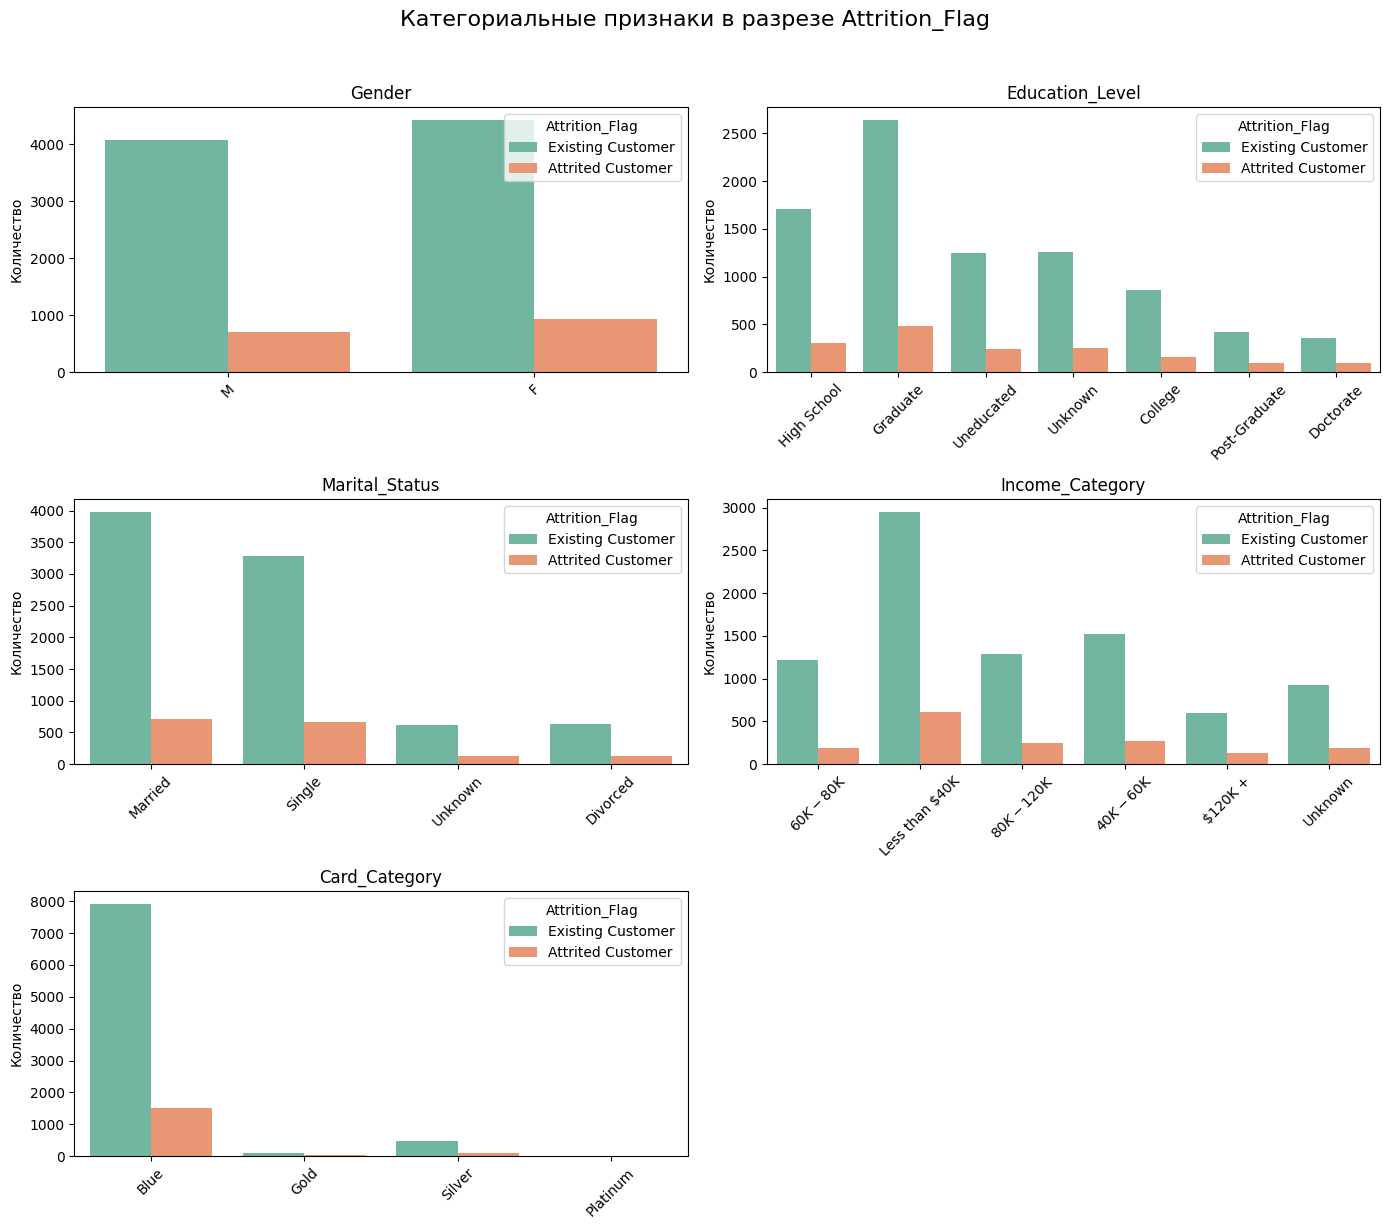

In [11]:
categorical_features = [
    'Gender',
    'Education_Level',
    'Marital_Status',
    'Income_Category',
    'Card_Category'
]

fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(14, 12))
axes = axes.flatten()

for i, feature in enumerate(categorical_features):
    sns.countplot(data=df, x=feature, hue='Attrition_Flag', palette='Set2', ax=axes[i])
    axes[i].set_title(f'{feature}', fontsize=12)
    axes[i].set_xlabel('')
    axes[i].set_ylabel('Количество')
    axes[i].tick_params(axis='x', rotation=45)

fig.delaxes(axes[-1])

plt.suptitle('Категориальные признаки в разрезе Attrition_Flag', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

###Анализ категориальных признаков и связи с оттоком

Для анализа были выбраны следующие категориальные признаки:
- `Gender` (Пол)
- `Education_Level` (Уровень образования)
- `Marital_Status` (Семейное положение)
- `Income_Category` (Категория дохода)
- `Card_Category` (Тип карты)

####Основные наблюдения:

- **Gender (Пол):**
  - Женщин и мужчин примерно поровну.
  - Отток у женщин немного выше, чем у мужчин.
  - Может быть важным признаком в комбинации с другими.

- **Education_Level (Образование):**
  - Больше всего клиентов с уровнями *Graduate*, *College* и *High School*.
  - У клиентов с высшим образованием (*Doctorate*, *Post-Graduate*) наблюдается повышенный отток.
  - возможно объединение редких категорий в одну.

- **Marital_Status (Семейное положение):**
  - Преобладают клиенты со статусом *Married*, затем *Single*.
  - У *Single* отток немного выше.

- **Income_Category (Доход):**
  - Клиенты с доходом *Less than $40K* составляют основную массу и чаще отказываются от карты.
  - У клиентов с высокими доходами ($120K+) — меньше наблюдений, но отток ниже

- **Card_Category (Тип карты):**
  - Почти все клиенты имеют карту *Blue*.
  - У клиентов с премиальными картами (*Platinum*, *Gold*) — выше отток, несмотря на малое количество.



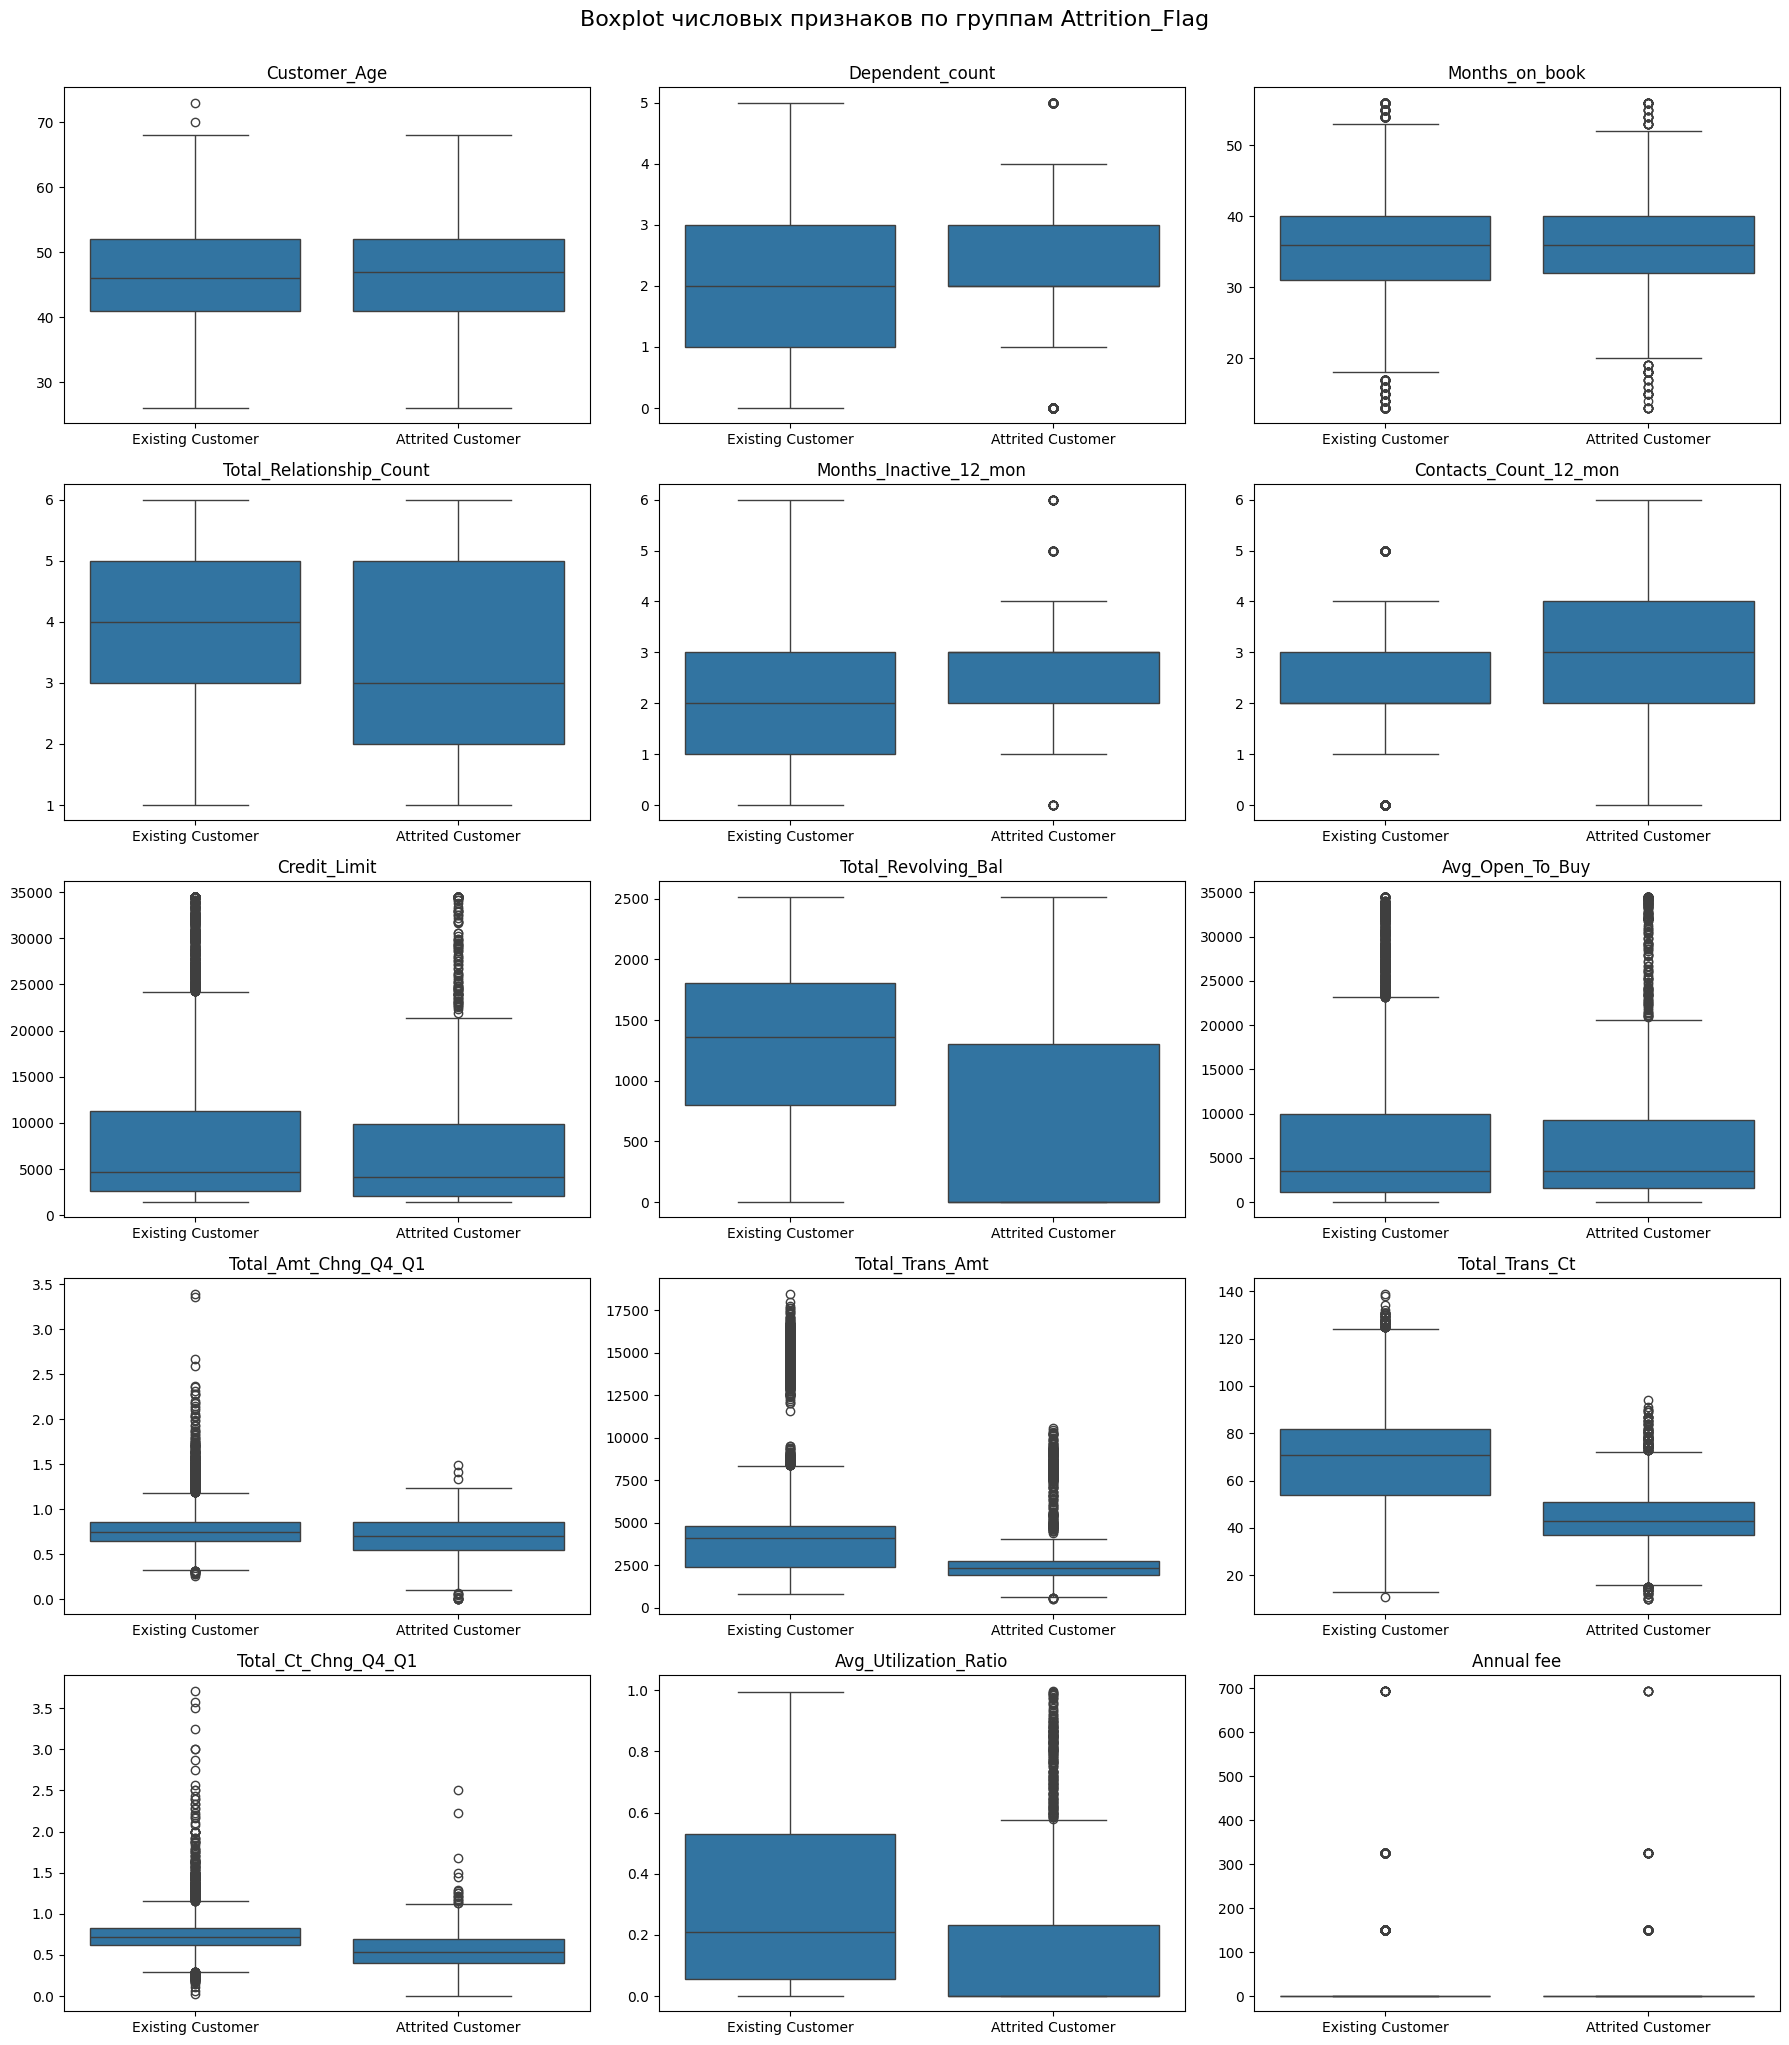

In [19]:

df_2['Attrition_Binary'] = df_2['Attrition_Flag'].map({
    'Attrited Customer': 1,
    'Existing Customer': 0
})

# Числовые признаки для анализа
features_to_plot = [
    'Customer_Age', 'Dependent_count', 'Months_on_book', 'Total_Relationship_Count',
    'Months_Inactive_12_mon', 'Contacts_Count_12_mon', 'Credit_Limit', 'Total_Revolving_Bal',
    'Avg_Open_To_Buy', 'Total_Amt_Chng_Q4_Q1', 'Total_Trans_Amt', 'Total_Trans_Ct',
    'Total_Ct_Chng_Q4_Q1', 'Avg_Utilization_Ratio', 'Annual fee'
]

n = len(features_to_plot)
ncols = 3
nrows = math.ceil(n / ncols)

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(18, nrows * 4))
axes = axes.flatten()

for i, feature in enumerate(features_to_plot):
    sns.boxplot(data=df_2, x='Attrition_Flag', y=feature, ax=axes[i])
    axes[i].set_title(feature)
    axes[i].set_xlabel('')
    axes[i].set_ylabel('')

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.suptitle('Boxplot числовых признаков по группам Attrition_Flag', fontsize=16, y=1.02)
plt.show()


In [26]:
# Числовая статистика по признакам для двух групп клиентов: ушедшие и оставшиеся
statistical_summary = df_2.groupby('Attrition_Flag')[[
    'Customer_Age', 'Dependent_count', 'Months_on_book', 'Total_Relationship_Count',
    'Months_Inactive_12_mon', 'Contacts_Count_12_mon', 'Credit_Limit', 'Total_Revolving_Bal',
    'Avg_Open_To_Buy', 'Total_Amt_Chng_Q4_Q1', 'Total_Trans_Amt', 'Total_Trans_Ct',
    'Total_Ct_Chng_Q4_Q1', 'Avg_Utilization_Ratio', 'Annual fee'
]].describe().transpose()


In [27]:
statistical_summary

Attrition_Flag      Attrited Customer  Existing Customer
Customer_Age count        1627.000000        8500.000000
             mean           46.659496          46.262118
             std             7.665652           8.081157
             min            26.000000          26.000000
             25%            41.000000          41.000000
...                               ...                ...
Annual fee   min             0.000000           0.000000
             25%             0.000000           0.000000
             50%             0.000000           0.000000
             75%             0.000000           0.000000
             max           695.000000         695.000000

[120 rows x 2 columns]

###Анализ числовых признаков и их связи с оттоком

Мы проанализировали 14 ключевых числовых признаков с помощью boxplot-графиков, разделив выборку по целевой переменной `Attrition_Flag`.

####Основные наблюдения:

- **Customer_Age (Возраст клиента):**
  - Распределения возраста у ушедших и оставшихся клиентов **практически идентичны**
  - Медианные значения совпадают, а размах (25–75%) отличается незначительно
  -Возраст точно **не является ключевым фактором** оттока.

- **Dependent_count (Количество иждивенцев)**
  - Распределение **почти идентичное**
  - Среднее количество иждивенцев чуть выше у ушедших
  - Переменная влияет слабо, значимых различий не выявлено

- **Months_on_book (Стаж клиента в банке):**
  - Ушедшие и оставшиеся клиенты имеют **почти иденичную длительность сотрудничества** с банком.
  - Незначительное различие в среднем стаже **не позволяет сделать уверенный вывод** о влиянии стажа на отток.

- **Months_Inactive_12_mon (Месяцы неактивности)**
  - Ушедшие были **менее активны**: медиана 3 против 2.
  - Длительная неактивность — сильный сигнал возможного ухода

- **Total_Relationship_Count (Связи с банком):**
  - Ушедшие клиенты имели **меньше банковских продуктов**.
  - Признак имеет чёткую связь с оттоком — **важный для модели**.

- **Contacts_Count_12_mon (Контакты за 12 мес):**
  - Ушедшие клиенты в среднем **чаще взаимодействовали с банком**, чем оставшиеся.
  - Это может указывать на наличие проблем или неудовлетворённость, которые побуждали их чаще обращаться.
  - Возможно, частые обращения не решали проблемы клиента и только усиливали желание уйти.


- **Credit_Limit (Кредитный лимит):**
  - В среднем выше у оставшихся, но много выбросов
  - вряд ли будет полезным признаком

- **Total_Revolving_Bal (Суммарная задолженность по карте)**
  - Ушедшие клиенты имеют значительно меньшую задолженность по кредитной карте, чем оставшиеся
  - Это может указывать на то, что они реже пользовались кредитными средствами, были менее вовлечены в финансовые продукты банка, либо предпочитали погашать задолженность сразу
  - Также возможно, что клиенты с высокой активностью и задолженностью получают более выгодные условия (бонусы, программы лояльности) и поэтому склонны оставаться

- **Total_Amt_Chng_Q4_Q1 (Изменение суммы транзакций в Q4 по сравнению с Q1)**
  - Ушедшие клиенты демонстрируют чуть меньший прирост транзакционной активности: медиана — 0.701 против 0.743 у оставшихся; среднее значение — 0.69 против 0.77
  - Это может указывать на снижение интереса к продуктам банка перед уходом — клиенты меньше тратили, реже пользовались картой
  - У оставшихся клиентов также больше высоких значений (максимум 3.4 против 1.49), что может говорить о наличии лояльных клиентов с высокой активностью
  - Таким образом, низкая динамика изменения суммы транзакций может быть потенциальным индикатором риска оттока


- **Avg_Open_To_Bu (средняя доступная сумма для покупок)**
  - Медианные значения практически идентичны между группами: 3488.0 у ушедших и 3469.5 у оставшихся.
  - Средние значения также практически не отличаются.
  - Распределения выглядят схожими, хотя у текущих клиентов чуть больше разброс (верхний квартиль выше — 9978.25 против 9257.5)
  - переменная Avg_Open_To_Buy не демонстрирует существенной разницы между группами. Это значит, что средний доступный объем средств на покупку, как правило, не связан напрямую с уходом клиента. Метрика неинформативна для предсказания оттока

- **Total_Trans_Amt (Общая сумма транзакций)**
  - Ушедшие клиенты совершают заметно меньше транзакций по объему, чем оставшиеся: медианное значение составляет 2329 против 4100
  - Также среднее значение значительно ниже у ушедших (3095 против 4654), что указывает на менее активное использование карты
  - Возможная причина оттока — низкая вовлеченность клиента в использование продуктов банка. Менее активные пользователи могут не видеть ценности в удержании карты
  - Также возможно, что банк активнее работает с высокоактивными клиентами, способствуя их удержанию

- **Total_Trans_Ct (Количество транзакций)**
  - Ушедшие клиенты совершают существенно меньше транзакций, чем оставшиеся:
    - Медиана (50%): 43 у ушедших vs 71 у оставшихся
    - Среднее: 44.9 у ушедших vs 68.7 у оставшихся
  - Это говорит о значительно более низкой транзакционной активности среди клиентов, покинувших банк
  - Вероятно, низкая частота использования услуг указывает на слабую вовлечённость в работу с банком
  - Активные клиенты, напротив, чаще совершают операции и, возможно, получают бонусы или программы лояльности, повышающие их удержание


- **Total_Ct_Chng_Q4_Q1 (Изменение числа транзакций в Q4 по сравнению с Q1)**
  -Клиенты, которые остались, демонстрировали большую положительную динамику в транзакционной активности между кварталами.
  - Это может говорить о росте интереса к продуктам банка или об увеличении доверия. Ушедшие же клиенты чаще демонстрировали стабильное или снижающееся поведение, что может сигнализировать о потере интереса к услугам банка

- **Avg_Utilization_Ratio (Средняя доля использования кредитного лимита)**
  - Ушедшие клиенты в среднем использовали меньшую долю кредитного лимита, чем оставшиеся
  - У текущих клиентов больше разброс значений и более высокая верхняя четверть
  - Это может говорить о том, что клиенты, активно использующие кредитный лимит, более вовлечены в банковские услуги и с меньшей вероятностью отказываются от обслуживания.
  - Низкий уровень использования лимита у ушедших клиентов может свидетельствовать о недостатке интереса к продукту или наличии альтернативных источников кредитования.



**Ключевые выводы из по числоовым и категориальным признакам по оттоку клиентов**

- **Снижение активности — главный признак риска ухода**  
  Ушедшие клиенты совершают меньше транзакций (`Total_Trans_Ct`, `Total_Trans_Amt`) и демонстрируют слабую динамику активности (`Total_Ct_Chng_Q4_Q1`, `Total_Amt_Chng_Q4_Q1`).

- **Меньшее использование кредитных продуктов**  
  Ушедшие реже используют кредитный лимит (`Avg_Utilization_Ratio`, `Total_Revolving_Bal`) → низкая вовлечённость в банковские услуги.

- **Частые обращения в поддержку — возможный сигнал недовольства**  
  Ушедшие чаще контактировали с банком (`Contacts_Count_12_mon`), что может указывать на нерешённые проблемы.

- **Соц-демографические признаки влияют слабо**  
  Возраст, доход, образование и семейное положение — не ключевые факторы, но могут усиливать поведенческие паттерны.

- **Повышенный отток среди владельцев премиальных карт**  
  `Gold` и `Platinum` карты сопровождаются более высоким оттоком — вероятно, из-за несоответствия ожиданий.

- **Что важно**
- Поведенческие метрики — основа для моделей
- Низкая активность + частые обращения = зона риска
- Премиальные клиенты требуют отдельного внимания



###ВОТ ТУТ ЗАКАНЧИВАЕТСЯ ТО, ЧТО Я СДЕЛАЛА

**Дропаем:**
- CLIENTNUM лишний, не несет смысловой нагрузки
- Population, % of Total Population тоже дропаем, полезно рассмотреть на уровне EDA, но в МЛ будет шум
- Card_Category и Card - есть Annual Fee, который более информативный, чем категории.

**Переведем в бинарный формат:**
- Attrition_Flag — целевая переменная, ее мы переведем в бинарный формат 1 и 0
- Аналогично, переведем пол в бинарный формат

**Что делать с возрастными группами?**


Можем вывести возрастную группу в отдельную категорию. Она может как создать шум, так и показать новые зависимости. **Есть смысл поделить отсюда всё на два датасета** — 1. с закодированной группой (ordinal encoding: самая молодая группа = 0, постарше = 1 и т.д.) и 2. без группы совсем.
- Иными словами, age_group в одном датасете дропнуть, в другом датасете оставить


**Окончательная кодировка признаков**


Далее, из каждого сделать еще два датасета, где мы для разных моделей МО по-разному кодируем признаки. Один для деревьев (град. бустинг, деревья), другой для алгоритмов на основе расстояний (KNN, лог. регрессия). Тогда по-разному закодируем фичи:
- для деревьев: education level, marital status - OHE, а income category — ВНИМАНИЕ! — ordinal encoding, где unknown будет -1, и отдельный флаг, является ли поле unknown
- для моделей на расстоянии: income category, marital status, education level - все OHE

**Бэйслайн**
- Не заморачиваемся с возрастными группами и удаляем их
- Удаляем образование как самый объемный из категориальных признаков
- Остальные закодируем через OHE

In [ ]:
df_base = df_2.copy()  # копия, над которой будут проделываться дальнейшие манипуляции

,CLIENTNUM,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio,Age Group,Population,% of Total Population,Card,Annual fee
0,768805383,Existing Customer,45,M,3,High School,Married,$60K - $80K,Blue,39,5,1,3,12691.0,777,11914.0,1.335,1144,42,1.625,0.061,45 to 49 years,20051874.0,0.0603,Blue Cash Everyday Card,0
1,818770008,Existing Customer,49,F,5,Graduate,Single,Less than $40K,Blue,44,6,1,2,8256.0,864,7392.0,1.541,1291,33,3.714,0.105,45 to 49 years,20051874.0,0.0603,Blue Cash Everyday Card,0
2,713982108,Existing Customer,51,M,3,Graduate,Married,$80K - $120K,Blue,36,4,1,0,3418.0,0,3418.0,2.594,1887,20,2.333,0.000,50 to 54 years,20795839.0,0.0626,Blue Cash Everyday Card,0
3,769911858,Existing Customer,40,F,4,High School,Unknown,Less than $40K,Blue,34,3,4,1,3313.0,2517,796.0,1.405,1171,20,2.333,0.760,40 to 44 years,21239767.0,0.0639,Blue Cash Everyday Card,0
4,709106358,Existing Customer,40,M,3,Uneducated,Married,$60K - $80K,Blue,21,5,1,0,4716.0,0,4716.0,2.175,816,28,2.500,0.000,40 to 44 years,21239767.0,0.0639,Blue Cash Everyday Card,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10122,772366833,Existing Customer,50,M,2,Graduate,Single,$40K - $60K,Blue,40,3,2,3,4003.0,1851,2152.0,0.703,15476,117,0.857,0.462,50 to 54 years,20795839.0,0.0626,Blue Cash Everyday Card,0
10123,710638233,Attrited Customer,41,M,2,Unknown,Divorced,$40K - $60K,Blue,25,4,2,3,4277.0,2186,2091.0,0.804,8764,69,0.683,0.511,40 to 44 years,21239767.0,0.0639,Blue Cash Everyday Card,0
10124,716506083,Attrited Customer,44,F,1,High School,Married,Less than $40K,Blue,36,5,3,4,5409.0,0,5409.0,0.819,10291,60,0.818,0.000,40 to 44 years,21239767.0,0.0639,Blue Cash Everyday Card,0
10125,717406983,Attrited Customer,30,M,2,Graduate,Unknown,$40K - $60K,Blue,36,4,3,3,5281.0,0,5281.0,0.535,8395,62,0.722,0.000,30 to 34 years,23056981.0,0.0694,Blue Cash Everyday Card,0


In [ ]:
df_base.drop(['CLIENTNUM', 'Population', '% of Total Population', 'Card', 'Card_Category'], axis=1, inplace=True)  # дропаем вышеупомянутое

In [ ]:
# создаем два словаря для кодировки

target_map = {
    'Existing Customer': 0,
    'Attrited Customer': 1
}

gender_map = {
    'F': 0,
    'M': 1
}

In [ ]:
# закодируем таргет и гендер, потом удалим оригинальные столбцы

df_base['Is_Male'] = df_base['Gender'].map(gender_map)
df_base['Target'] = df_base['Attrition_Flag'].map(target_map)
df_base.drop(['Attrition_Flag', 'Gender'], axis=1, inplace=True)
df_base.head()

In [ ]:
df_base.head()

,Customer_Age,Dependent_count,Education_Level,Marital_Status,Income_Category,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio,Age Group,Annual fee,Is_Male,Target
0,45,3,High School,Married,$60K - $80K,39,5,1,3,12691.0,777,11914.0,1.335,1144,42,1.625,0.061,45 to 49 years,0,1,0
1,49,5,Graduate,Single,Less than $40K,44,6,1,2,8256.0,864,7392.0,1.541,1291,33,3.714,0.105,45 to 49 years,0,0,0
2,51,3,Graduate,Married,$80K - $120K,36,4,1,0,3418.0,0,3418.0,2.594,1887,20,2.333,0.000,50 to 54 years,0,1,0
3,40,4,High School,Unknown,Less than $40K,34,3,4,1,3313.0,2517,796.0,1.405,1171,20,2.333,0.760,40 to 44 years,0,0,0
4,40,3,Uneducated,Married,$60K - $80K,21,5,1,0,4716.0,0,4716.0,2.175,816,28,2.500,0.000,40 to 44 years,0,1,0


In [ ]:
# здесь мы сделаем бэйслайн

df_ml_baseline = df_base.copy()
df_ml_baseline.drop(['Age Group', 'Education_Level'], axis=1, inplace=True)

In [ ]:
# применим Ohe-Hot Encoding к категориальным признакам

df_ml_baseline = pd.get_dummies(
    df_ml_baseline,
    columns=df_ml_baseline.select_dtypes(object).columns,
    drop_first=True
)

# df_ml_baseline.head() - посмотреть, че там

,Customer_Age,Dependent_count,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio,Annual fee,Is_Male,Target,Marital_Status_Married,Marital_Status_Single,Marital_Status_Unknown,Income_Category_$40K - $60K,Income_Category_$60K - $80K,Income_Category_$80K - $120K,Income_Category_Less than $40K,Income_Category_Unknown
0,45,3,39,5,1,3,12691.0,777,11914.0,1.335,1144,42,1.625,0.061,0,1,0,True,False,False,False,True,False,False,False
1,49,5,44,6,1,2,8256.0,864,7392.0,1.541,1291,33,3.714,0.105,0,0,0,False,True,False,False,False,False,True,False
2,51,3,36,4,1,0,3418.0,0,3418.0,2.594,1887,20,2.333,0.000,0,1,0,True,False,False,False,False,True,False,False
3,40,4,34,3,4,1,3313.0,2517,796.0,1.405,1171,20,2.333,0.760,0,0,0,False,False,True,False,False,False,True,False
4,40,3,21,5,1,0,4716.0,0,4716.0,2.175,816,28,2.500,0.000,0,1,0,True,False,False,False,True,False,False,False


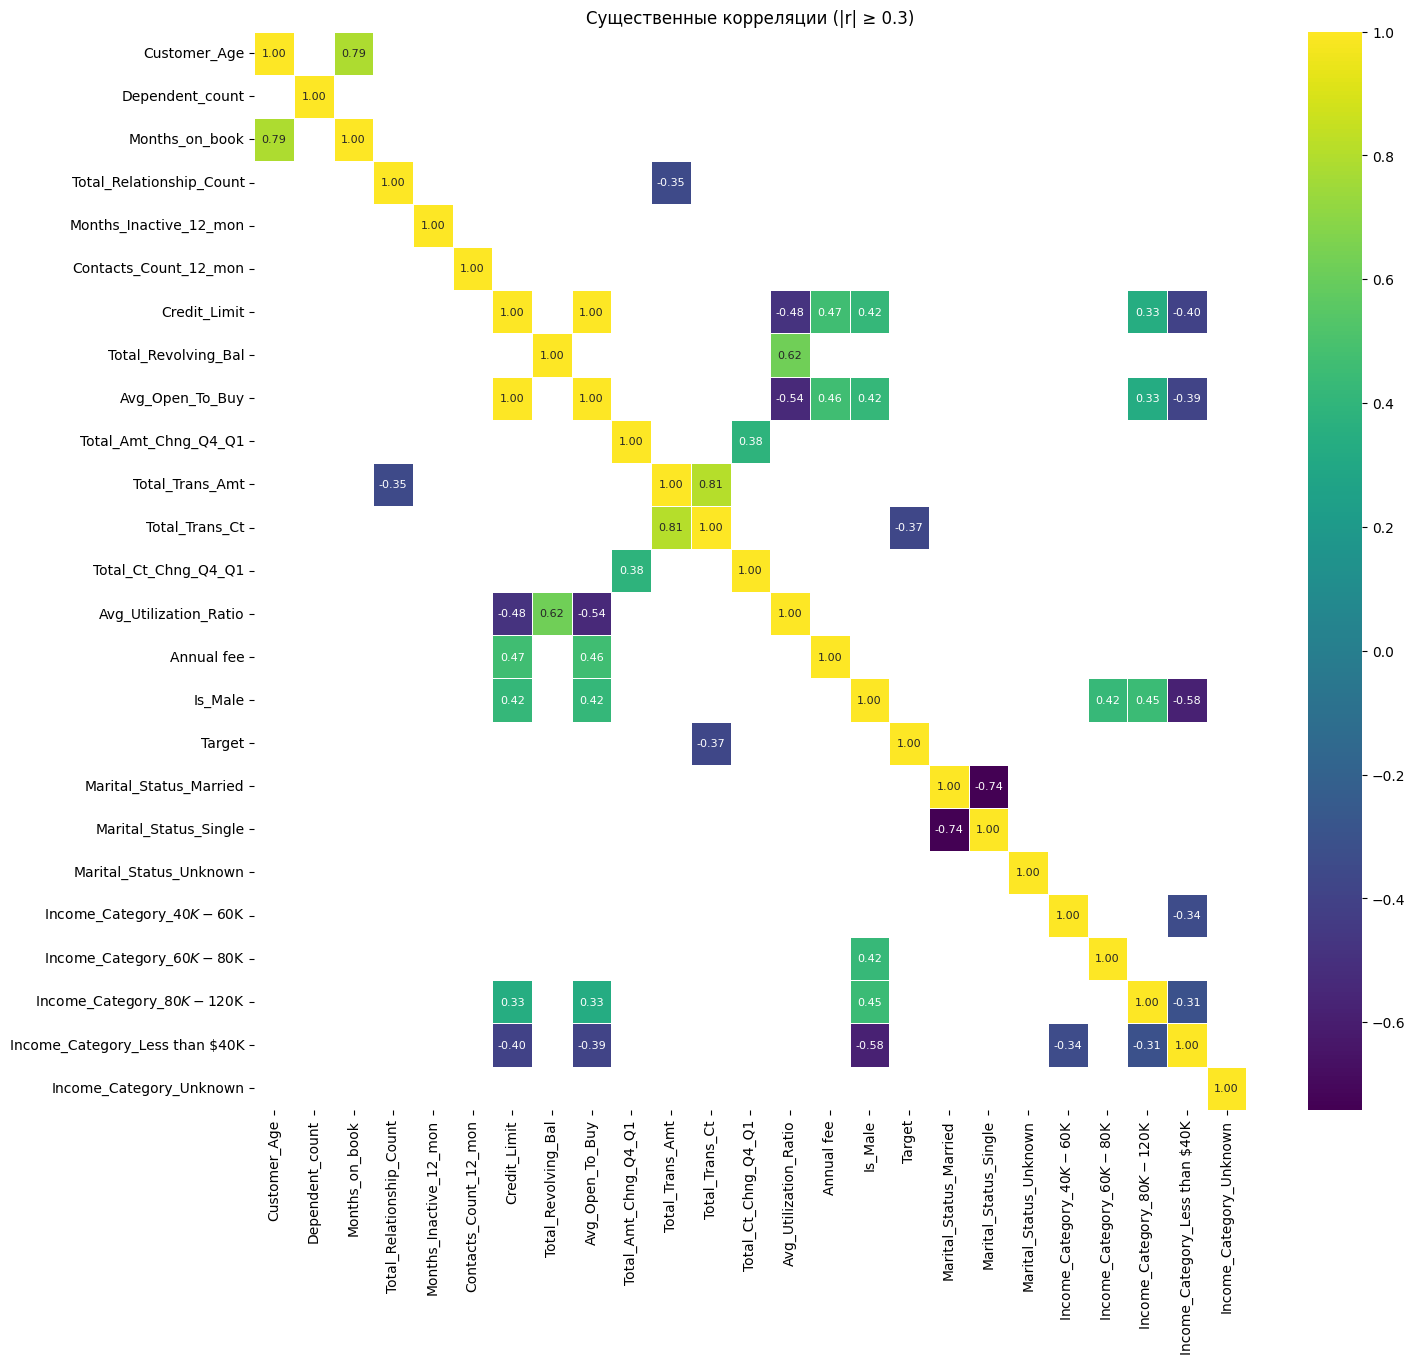

In [ ]:
# построим матрицу корреляции, узнаем, что в бейслайне больше всего коррелирует - коллинеарные признаки можно будет убрать из других датафреймов, еще до того, как закодируем возрастную группу

corr = df_ml_baseline.corr()
mask = np.abs(corr) < 0.3  # Adjust threshold as needed

plt.figure(figsize=(16, 14))
sns.heatmap(corr, mask=mask, cmap='viridis', annot=True, fmt=".2f",
            annot_kws={"size": 8}, linewidths=.5)
plt.title('Существенные корреляции (|r| ≥ 0.3)')
plt.show()

In [ ]:
# датасет с закодированной возрастной группой

df_ml_age = df_base.copy()

age_map = {
    '25 to 29 years': 0,
    '30 to 34 years': 1,
    '35 to 39 years': 2,
    '40 to 44 years': 3,
    '45 to 49 years': 4,
    '50 to 54 years': 5,
    '55 to 59 years': 6,
    '60 to 64 years': 7,
    '65 to 69 years': 8,
    '70 to 74 years': 9
}

df_ml_age['Encoded_Age_Group'] = df_ml_age['Age Group'].map(age_map)
df_ml_age.drop(['Age Group'], axis=1, inplace=True)

In [ ]:
# датасет с без возрастной группы

df_ml_no_age = df_base.copy()
df_ml_no_age.drop(['Age Group'], axis=1, inplace=True)